<a href="https://colab.research.google.com/github/zzhenxi/Semantic-Textual-Similarity-API/blob/main/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence-transformers transformers wandb

     |████████████████████████████████| 79 kB 4.8 MB/s 
     |████████████████████████████████| 3.8 MB 36.5 MB/s 
     |████████████████████████████████| 1.7 MB 44.6 MB/s 
     |████████████████████████████████| 1.2 MB 53.5 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 596 kB 45.0 MB/s 
     |████████████████████████████████| 895 kB 77.8 MB/s 
     |████████████████████████████████| 6.5 MB 53.9 MB/s 
     |████████████████████████████████| 181 kB 65.3 MB/s 
     |████████████████████████████████| 144 kB 72.5 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=8bd0fb7e9ade49415de16f807230b20ccf072e607d7c09bba11deccbd39bc3d1
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=88

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/wanted_assignment/assignment3/dataset")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.전처리 및 EDA
- 유사도 비교 시 불필요한 부분 제거
  - 홈페이지 주소, 특수문자
- 데이터 특징
 - 굉장히 적은 Test set
 - 불균형한 라벨 분포를 가진 Train set 

In [ ]:
import json
import pandas as pd
import re
from transformers import ElectraTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

- KoELECTRA에서 사용한 tokenizer

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

Downloading:   0%|          | 0.00/257k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

In [ ]:
with open("klue-sts-v1.1_train.json", 'r') as file:
    train = json.load(file)

with open("klue-sts-v1.1_dev.json", 'r') as file:
    test = json.load(file)

In [ ]:
train[0]

{'annotations': {'agreement': '0:0:0:2:5:0',
  'annotations': [3, 4, 4, 4, 3, 4, 4],
  'annotators': ['07', '13', '15', '10', '12', '02', '19']},
 'guid': 'klue-sts-v1_train_00000',
 'labels': {'binary-label': 1, 'label': 3.7, 'real-label': 3.714285714285714},
 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.',
 'source': 'airbnb-rtt'}

In [ ]:
def split_by_source(file):
  """
  source별로 데이터를 분리해서 반환.
  """
  data_airbnb = [data for data in file if "airbnb" in data['source']]
  data_policy = [data for data in file if "policy" in data['source']]
  data_parak = [data for data in file if "paraKQC" in data['source']]

  return data_airbnb, data_policy, data_parak

train_airbnb, train_policy, train_parak = split_by_source(train)
test_airbnb, test_policy, test_parak = split_by_source(test)

- 굉장히 적은 테스트 데이터셋

In [ ]:
print(len(train_airbnb), len(train_policy), len(train_parak))
print(len(test_airbnb), len(test_policy), len(test_parak))

5371 2344 3953
255 132 132


In [ ]:
def make_df(dataset): 
  """
  데이터셋을 입력받아 DataFrame으로 변환.
  """
  sentence1 = []
  sentence2 = []
  real_label = []
  binary_label = []

  for data in dataset:
    sentence1.append((data['sentence1']))
    sentence2.append((data['sentence2']))
    real_label.append((data['labels']['real-label']))
    binary_label.append((data['labels']['binary-label']))
  
  df = pd.DataFrame(
      {'sentence1' : sentence1,
       "sentence2" : sentence2,
       "real_label" : real_label,
       "binary_label" : binary_label})
  
  return df

In [ ]:
train_airbnb_df, train_policy_df, train_parak_df = make_df(train_airbnb), make_df(train_policy), make_df(train_parak)
test_airbnb_df, test_policy_df, test_parak_df = make_df(test_airbnb), make_df(test_policy), make_df(test_parak)

- 전처리 진행

In [ ]:
import re
import string

def normalize_answer(s):
    def remove_(text):
        ''' 불필요한 기호 제거 '''
        text = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', text)
        return text

    def white_space_fix(text):  #공백을 하나로 줄이는 코드
        return ' '.join(text.split())

    def remove_punc(text): # 반점 제거
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text): # 소문자로 변경
        return text.lower()

    return white_space_fix(remove_punc(lower(remove_(s))))

def preprocess(sen):
  sen =  re.sub("((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*", "",sen)
  sen = normalize_answer(sen)
  
  return sen

def apply_preprocess(df):
  """
  텍스트 전처리 진행.
  """
  df['sentence1'] = df['sentence1'].apply(normalize_answer).apply(preprocess)
  df['sentence2'] = df['sentence2'].apply(normalize_answer).apply(preprocess)

  return df

In [ ]:
train_airbnb_df = apply_preprocess(train_airbnb_df)
test_airbnb_df = apply_preprocess(test_airbnb_df)

train_policy_df = apply_preprocess(train_policy_df)
test_policy_df = apply_preprocess(test_policy_df)

train_parak_df = apply_preprocess(train_parak_df)
test_parak_df = apply_preprocess(test_parak_df)

In [ ]:
def tokenize_sentence(df):
  """
  EDA에 활용할 수 있도록 문장을 토큰화.
  """
  global tokenizer
  df['sentence1_tok'] = df['sentence1'].apply(tokenizer).apply(lambda x : x['input_ids'])
  df['sentence2_tok'] = df['sentence2'].apply(tokenizer).apply(lambda x : x['input_ids'])
  df['sentence1_tok_len'] = df['sentence1_tok'].apply(len)
  df['sentence2_tok_len'] = df['sentence2_tok'].apply(len)

  return df

In [ ]:
train_airbnb_df, train_policy_df, train_parak_df = tokenize_sentence(train_airbnb_df), tokenize_sentence(train_policy_df), tokenize_sentence(train_parak_df)
test_airbnb_df, test_policy_df, test_parak_df = tokenize_sentence(test_airbnb_df), tokenize_sentence(test_policy_df), tokenize_sentence(test_parak_df)

In [ ]:
train_airbnb_df

,sentence1,sentence2,real_label,binary_label,sentence1_tok,sentence2_tok,sentence1_tok_len,sentence2_tok_len
0,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다,3.714286,1,"[2, 12175, 6767, 4034, 23689, 2990, 4219, 6517...","[2, 11311, 14398, 4234, 6767, 4034, 2990, 4325...",17,24
1,호스트의 답장이 늦으나 개선될 것으로 보입니다,호스트 응답이 늦었지만 개선될 것으로 보입니다,4.714286,1,"[2, 21124, 4234, 25190, 4007, 2336, 6742, 6707...","[2, 21124, 8020, 4007, 2336, 4480, 17164, 6707...",13,13
2,지하철을 타도 30분안에는 이동이 가능합니다,지하철을 탄다고 해도 30분이면 그곳에 도착할 수 있어요,4.000000,1,"[2, 8779, 4292, 26778, 6332, 4473, 4225, 4073,...","[2, 8779, 4292, 30040, 4219, 6571, 6332, 4473,...",14,18
3,새로운 친구들을 만나고 싶을때 아주 추천합니다,새로운 친구들을 만나고 싶을 때 추천합니다,4.428571,1,"[2, 6436, 6554, 4006, 4292, 6654, 4219, 3018, ...","[2, 6436, 6554, 4006, 4292, 6654, 4219, 3018, ...",14,13
4,2층 부엌과 거실 시설도 굉장히 좋고 히터도 잘 작동합니다,주방시설 상태도 좋고 욕실도 깨끗합니다,0.714286,0,"[2, 22, 4370, 14201, 4047, 12860, 6650, 4086, ...","[2, 11513, 14398, 6432, 4086, 3311, 4219, 1791...",17,12
...,...,...,...,...,...,...,...,...
5366,그녀에게 보답할 수 있는 게 좋은 리뷰를 작성하는 일 뿐이라는게 안타깝기만 하네요,제가 할 수 있는 것은 그녀가 좋은 평론을 쓴 것에 대한 좋은 평론을 쓰는 것뿐이라...,2.333333,0,"[2, 6453, 4073, 4325, 17163, 4519, 2967, 3249,...","[2, 3288, 4070, 3758, 2967, 3249, 4034, 2048, ...",28,34
5367,세탁할 생각이 있는 분들은 가능하면 여기서 하세요,빨래를 하고 싶으면 여기서 하세요,2.571429,0,"[2, 11065, 4519, 6243, 4007, 3249, 4034, 2801,...","[2, 16651, 4110, 14227, 3018, 9234, 6421, 4129...",17,11
5368,일단 방은 사진이랑 똑같고 매우 깨끗합니다,우선 방은 그림과 같고 매우 깨끗합니다,4.000000,1,"[2, 7128, 2741, 4112, 6471, 4007, 4294, 8007, ...","[2, 6863, 2741, 4112, 6906, 4047, 2024, 4219, ...",13,12
5369,그녀는 지속적으로 나에게 그녀가 만든 새로운 규칙을 매일 매일 이메일로 보냈다,그녀는 자신이 만든 새로운 규칙을 매일 끊임없이 제게 이메일로 보냈습니다,3.666667,1,"[2, 6453, 4034, 6732, 4199, 10749, 2236, 4073,...","[2, 6453, 4034, 6326, 4007, 6852, 6436, 8708, ...",22,18


In [ ]:
def viz_data(df, name = "None"):
  """
  Label 분포와 Token의 길이를 확인합니다.
  """
  sen1_tok_len = df['sentence1_tok_len']
  sen2_tok_len = df['sentence2_tok_len']
  real_label = df['real_label']
  binary_label = df['binary_label']

  fig, axs = plt.subplots(1, 6, figsize=(20, 5))

  sns.histplot(data = sen1_tok_len, binwidth=1, ax=axs[0])
  sns.boxplot(sen1_tok_len, ax=axs[1])
  sns.histplot(data = sen2_tok_len, binwidth=1, ax=axs[2])
  sns.boxplot(sen2_tok_len, ax=axs[3])
  sns.distplot(real_label, ax=axs[4])
  sns.histplot(data = binary_label, ax=axs[5])
  plt.suptitle(name)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/li

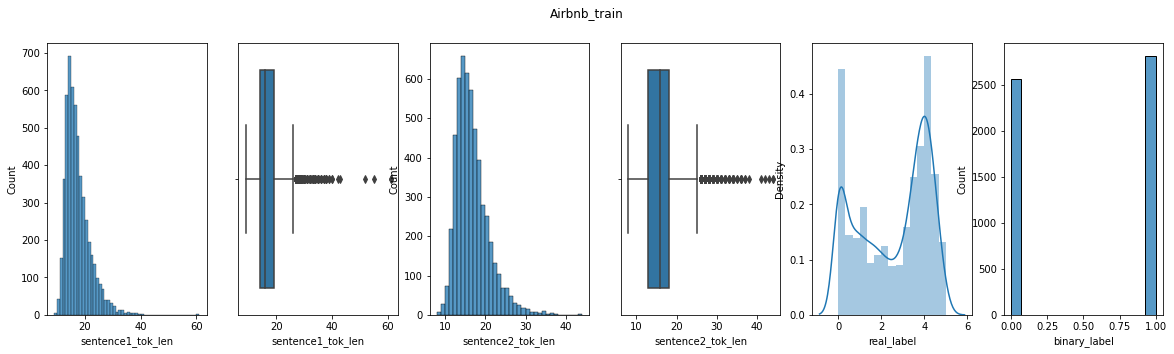

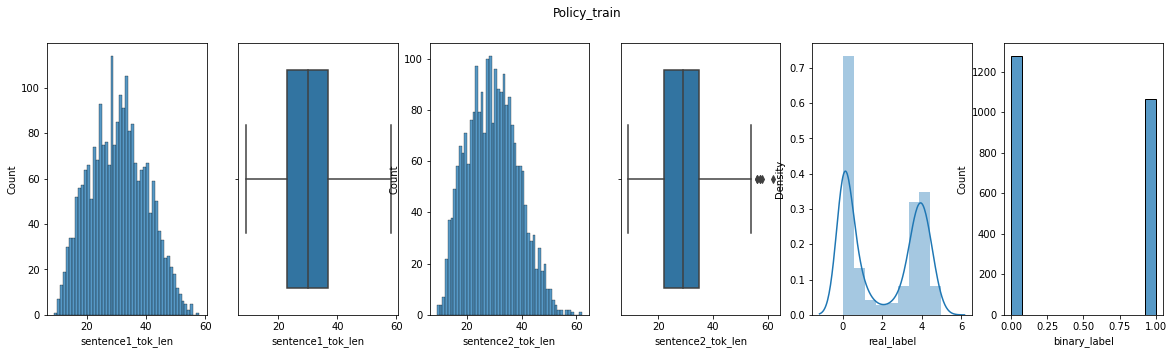

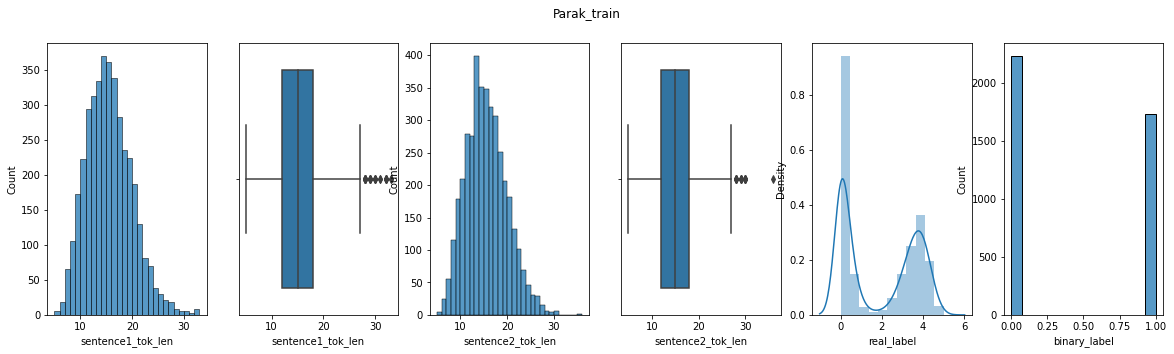

In [ ]:
viz_data(train_airbnb_df, "Airbnb_train")
viz_data(train_policy_df, "Policy_train")
viz_data(train_parak_df, "Parak_train")

- 불균형한 Train Label 분포
 - 0 , 4~5 사이에 몰려있음.
 - Source별로 Train/Valid 분리하면 불균형도가 더 커질 것.
 - 모두 합쳐서 Train/Valid 분리.

In [ ]:
train_df = pd.concat([train_airbnb_df, train_policy_df, train_parak_df])
test_df = pd.concat([test_airbnb_df, test_policy_df, test_parak_df])

- Concated Data
 - Train / Valid 분리로 일반화 성능을 개선하기엔 Label 1 ~ 3까지의 데이터 수가 매우 적음
 - 추후에 Data Augmentation 활용하여 개선 여지



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


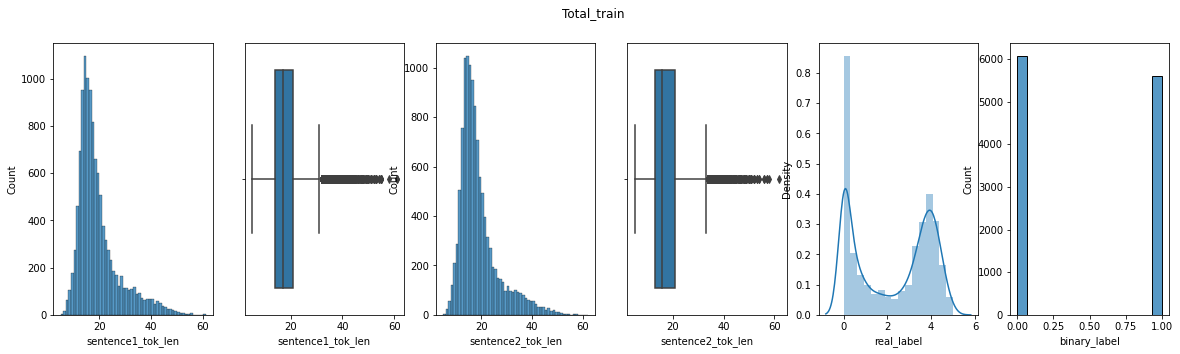

In [ ]:
viz_data(train_df, "Total_train")

In [ ]:
train_df = train_df.drop(['sentence1_tok_len', "sentence2_tok_len", "sentence1_tok", "sentence2_tok"], axis = 1)

### Train/Valid/Test 데이터 구성

- Stratify 사용시 불균일한 데이터를 그대로 따를 것으로 판단돼 Random Sampling으로 진행

In [ ]:
from sklearn.model_selection import train_test_split

train_data, valid_data = train_test_split((train_df), test_size=0.2, random_state = 42)
test_data = test_df.drop(['sentence1_tok_len', "sentence2_tok_len", "sentence1_tok", "sentence2_tok"], axis = 1)

In [ ]:
train_data = train_data.reset_index().drop(['index'], axis = 1)
valid_data = valid_data.reset_index().drop(['index'], axis = 1)
test_data = test_data.reset_index().drop(['index'], axis = 1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


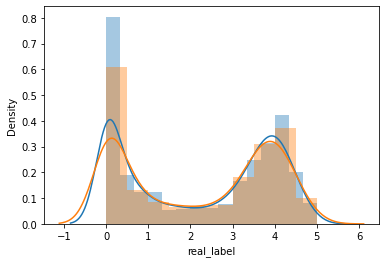

In [ ]:
sns.distplot(train_data['real_label'])
sns.distplot(valid_data['real_label'])

# 2.모델 선택


## A. 모델 설명 : [KoELECTRA v3](https://github.com/monologg/KoELECTRA)
ELECTRA

- 한국어 데이터 PLM 모델
- 34GB Corpus (나무위키, 뉴스, 위키, 모두의 말뭉치)
- SentencePiece Tokenizer
- 34000 Vocab   

### 1) 모델 선정 기준

**[pre-trained 모델의 dataset과의 유사성]**

- train dataset은 약 10,000개로(valid 포함) 충분한 숫자가 아니였음. → 한국어 pre-trained 모델을 fine-tuning하는 것이 좋다고 판단
- 나무위키, 뉴스, 위키, 모두의 말뭉치 등 34GB의 Corpus data로 학습돼 다양한 task에 활용될 수 있는 pretrained model이라고 판단

**[모델의 성능]**

KorSTS에서 SOTA 모델임과 동시에 또 다른 후보 모델이었던 Sentence BERT와 비교한 결과 학습 속도는 비교적 느리지만 평가지표(f1 socre, pearsonr)의 점수가 더 좋게 나왔기 때문에 해당 모델을 선택. 

**[모델의 활용 편의성]**

huggingface 라이브러리를 활용하여 tokenizing 및 학습이 가능하기 때문에, 짧은 시간 내에 성능 개선에 용이

In [ ]:
import numpy as np
import random
import torch
# seed
seed = 42
random.seed(seed), torch.manual_seed(seed), torch.cuda.manual_seed_all(seed)

(None, <torch._C.Generator at 0x7f189739ef70>, None)

In [ ]:
# device type
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"# available GPUs : {torch.cuda.device_count()}")
        print(f"GPU name : {torch.cuda.get_device_name()}")
    else:
        device = torch.device("cpu")
    return device
device = set_device()
device

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB


device(type='cuda')

### 2) 모델 입력, 출력 
STS는 0과 5사이의 유사도 연속적인 Label 값을 예측하는 Regression 문제   
따라서 입력으로 sentence pair와 label이 주어지고 출력으로 label 값을 얻음  

`ForSequenceClassification` 형태로 모델을 불러오면 Regression에 맞는 output을 자동으로 계산.
>>
ElectraClassificationHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Linear(in_features=768, out_features=2, bias=True)
)
>>

 `input` : (tokenized_sentence1, tokenized_sentence2), label    
 `output` : outputs.loss(MSELoss), outputs.logits(예측된 라벨)

In [ ]:
from transformers import ElectraForSequenceClassification, ElectraTokenizer
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels = 1)  # KoELECTRA-Base-v3
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator") 

Downloading:   0%|          | 0.00/431M [00:00<?, ?B/s]

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [ ]:
model.classifier

ElectraClassificationHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Linear(in_features=768, out_features=1, bias=True)
)

# 3.Training



## A. Dataset 구성
- 미리 만들어둔 DataFrame을 그대로 입력으로 활용할 수 있도록 CustomDataset 구현
- tokenized 데이터를 (sentence1, sentence2), label 형태로 반환할 수 있도록 collate_fn 구현

In [ ]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, random_split

class CustomDataset(Dataset):
    """
    데이터 프레임의 입력을 받아 (input, target) 형태의 Dataset 생성
    """
    def __init__(self, data) -> None: 
        self.data = data            
        self.input, self.label = list(zip(self.data['sentence1'], self.data['sentence2'])), self.data['real_label']

    def __len__(self):
        return len(self.label) # len(y)

    def __getitem__(self, index):
        return self.input[index], self.label[index] # getitem 호출 시 tuple 형태로 x, y 반환

In [ ]:
def custom_collate_fn(batch, max_length):
    """
  한 배치 내 문장(input)들을 tokenizing 한 후 텐서로 변환함. 
    """
    global tokenizer
  
    input_list, target_list = zip(*batch) #(input_list, target_list)를 list가 감싸고 있기 때문에 unpacking(*) 후에 zip으로 할당
    tensorized_input = tokenizer.batch_encode_plus(
        # input_list
        [(sentences[0], sentences[1]) for sentences in input_list],
        max_length = max_length, # 
        padding= "max_length",
        add_special_tokens=True,
        truncation=True,
        return_tensors='pt',
    )
    
    tensorized_label = torch.tensor(target_list)
  
    return tensorized_input, tensorized_label

In [ ]:
train_dataset = CustomDataset(train_data)
valid_dataset = CustomDataset(valid_data)
test_dataset = CustomDataset(test_data)

In [ ]:
test_data

,sentence1,sentence2,real_label,binary_label
0,무엇보다도 호스트분들이 너무 친절하셨습니다,무엇보다도 호스트들은 매우 친절했습니다,4.857143,1
1,주요 관광지 모두 걸어서 이동가능합니다,위치는 피렌체 중심가까지 걸어서 이동 가능합니다,1.428571,0
2,다만 도로와 인접해서 거리의 소음이 들려요,하지만 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다,3.714286,1
3,방안에 필요한 시설이 모두 있어서 매우 편리합니다,특히 숙소 근처에 안전한 실내 주차장이 있어서 편리합니다,1.142857,0
4,일본종교문화를 잘 이해하시는 분이 이용하시는 게 좋아요,그리고 슬리퍼를 하나 준비하시는 게 좋아요,0.000000,0
...,...,...,...,...
514,당신 부모님의 이메일 주소가 궁금해요,너희 부모님 메일 주소를 알려줄 수 있을까,4.000000,1
515,한메일 계정을 더 만드는건 유료니 그만 만들어,한메일 계정은 그만 만들고 네이버 계정으로 만들어,2.428571,0
516,지금 집안 습도가 얼마인지 확인할 수 있게 도와줘,집안 습도 어떤지 보고싶을 때는 뭐라고 해야하니,3.166667,1
517,메일을 보낼 때 도메인을 확인하고 일본이면 보내지마세요,제 다음 메일 계정엔 메일을 보내시면 안되니 메일을 보내실 때 조심해주세요,1.600000,0


In [ ]:
train_dataset[0]

(('보안에 문제가 있다는 다른 후기를 본 후 걱정을 많이 했습니다', '보안 문제가 있다는 다른 리뷰들을 보고 많이 걱정했어요'), 4.2)

- wandb 활용하기 위해서 우선 test_dataloader만 생성

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size = 32, sampler = SequentialSampler(test_dataset), collate_fn = partial(custom_collate_fn, max_length= 128))

## B. Wandb 사용을 위한 설정
- Sweep 마다 다른 데이터셋 생성
- Table 관련 설정
- Sweep_config 설정

In [ ]:
!pip install wandb
# api key 입력
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from functools import partial
def sweep_dataset(train_batch_size, valid_batch_size, max_length, train_dataset, valid_dataset):
    """
    sweep 과정에 활용될 데이터셋을 구성합니다.
    """
       
    train_dataloader = DataLoader(train_dataset, batch_size = train_batch_size, sampler = RandomSampler(train_dataset), \
        collate_fn = partial(custom_collate_fn, max_length= max_length))
    valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch_size, sampler = SequentialSampler(valid_dataset), \
        collate_fn = partial(custom_collate_fn, max_length= max_length))

    return train_dataloader, valid_dataloader

- Wandb.Table를 통해서 잘못 분류된 문장을 확인하기 위한 문장 decode

In [ ]:
def decoder(batch_input):
    """   
    인코딩된 문장을 입력 받아 special token을 제거한 뒤 decode 진행합니다.
    """   
    global tokenizer
    sentences = []   
    for input in batch_input:
        #[UNK] token만 남기고 제거.
        cleaned_input = [i for i in input if i > 4 or i == 1 or i == 3]
        #sep 지우기 위해서 [:-5]                   
        sentence = tokenizer.decode(cleaned_input)[:-5]
        sentences.append(sentence)
          
    return sentences

In [ ]:
sweep_config = {
    
    "name" : "wandb-sts",   
    "method": "bayes",
    "metric": {
        "name" : "total_valid_loss", 
        "goal" : "minimize"
                },
    
    "parameters": { 
        "epochs" : {
            "distribution" : "categorical",
            "values" : [4]},
        "learning_rate" : {
            "distribution" : "categorical",
            "values" : [1e-5, 3e-5, 5e-5]},                     
        "eps" : {
            "distribution" : "categorical",
            "values" : [1e-8]
        },
        "train_batch_size" : {
            "distribution" : "categorical",
            "values" : [32]
        },
        "valid_batch_size" : {
            "distribution" : "categorical",
            "values" : [32]
        },
        "weight_decay" : {
            "distribution" : "categorical",
            "values" : [0, 0.01]
        },
        "warm_up_ratio" : {
            "distribution" : "categorical",
            "values" : [0]
        },
        "max_length" : {
            "distribution" : "categorical",
            "values" : [128]
        },
        "grad_norm" : {
            "distribution" : "categorical",
            "values" : [1.0]
        },
    },         
    "early_terminate" : {
        "type": "hyperband", # metric이 2번 이상 개선되지 않을 경우 조기 종료
        "min_iter" : 2,
        "eta" : 2
        }
}

## C. Training에 필요한 기능 구현

### 1) Check Point 저장

In [ ]:
def save_checkpoint(model, optimizer, scheduler, epoch, loss):
    '''
    torch.save 함수 이용하여 model 정보 저장
    불필요한 반복방지 및 GPU memory 공간 renewal에  활용
    '''
    file_name = f'./model.ckpt.{loss:.2f}'
        
    # torch.save 함수 참고
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss' : loss
        }, 
        file_name
    )
    
    print(f"Saving epoch {epoch} checkpoint at {file_name}")

### 2) Validation 구현

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import f1_score

def validate(model, dataloader, device, wandb, text_table, epoch = 1):    
    """
    모델 검증 과정을 wandb로 기록합니다. 가장 성능이 좋은 모델을 저장히기 위해서 지표들을 반환합니다.
    """
    model.eval()
    
    total_loss = 0
    batch_count, batch_loss = 0, 0
    preds_list = None # 예측값 저장

    for step, batch in enumerate(dataloader):       
        batch_count += 1
        batch = tuple(item.to(device) for item in batch)

        batch_input, batch_label = batch

        with torch.no_grad():
            outputs = model(**batch_input, labels = batch_label.float()) 

        loss = outputs.loss #MSELoss
        preds = outputs.logits.squeeze()
        
        # 모델 예측 값과 Label 값 저장.
        if preds_list is None:
            preds_list = preds.detach().cpu().numpy()
            labels_list = batch_label.detach().cpu().numpy()
        else:
            preds_list = np.append(preds_list, preds.detach().cpu().numpy(), axis=0)
            labels_list = np.append(labels_list, batch_label.detach().cpu().numpy(), axis=0)        
        
        #loss 기록
        batch_loss += loss.item()
        total_loss += loss.item()

        #10개의 배치를 처리할 때마다 평균 loss 출력
        if (step % 10) == 0 and step != 0:  
            print(f"Step : {step + 1}, valid Loss : {batch_loss / batch_count:.4f}")
            wandb.log({'valid_loss': batch_loss / batch_count})    
            batch_loss, batch_count = 0, 0

            # 잘못 분류된 샘플 확인()
            preds_temp = np.where(preds.detach().cpu().numpy() >= 3, 1, 0)
            labels_temp = np.where(batch_label.detach().cpu().numpy() >= 3, 1, 0)           
            # 잘못 분류한 샘플 마스킹 후 log기록.
            mask = (preds_temp != labels_temp)
            # 문장을 확인하기 위해서 decode 진행
            sentences = decoder(batch_input['input_ids'][mask]) 
            # text_table에 잘못 분류된 문장과 True/Pred Label 기록        
            for sentence, true_label, pred_label in zip(sentences, labels_temp[mask], preds_temp[mask]):
                text_table.add_data(epoch, step + 1 , sentence, true_label, pred_label)              
                            
    # f1, pearson 유사도 계산    
    preds_f = np.where(preds_list >=3, 1, 0)
    labels_f = np.where(labels_list >=3, 1, 0)     
    f_score = f1_score(preds_f, labels_f) * 100
    p_score = pearsonr(preds_list, labels_list)[0] * 100  
    # 최종 loss 저장       
    total_valid_loss = total_loss / (step + 1)              
    #wandb log                
    wandb.log({'total_valid_loss': total_valid_loss, "total_f1_score ": f_score, "total_pearsonr" : p_score})     
    print('total_valid_loss : ', total_valid_loss, "total_f1_score : ",  f_score,  "total_pearsonr :",  p_score)   
    
    return total_valid_loss

### 3) Loss, optimizer, scheduler 정의
loss 는 label 입력시 MSE loss로 output 생성 -> 별도의 customizing 없이 model output 이용   
optimizer : AdamW   
epoch 및 scheduler 설정   
scheduler : get_linear_schedule_with_warmup   

In [ ]:
from torch.nn.utils import clip_grad_norm_

def sweep(model, train_dataloader, valid_dataloader, optimizer, scheduler, device, config, wandb, text_table):   
    """
    하이퍼 파라미터 과정을 wandb로 기록합니다.
    """
    # parameter, graident 변화 기록
    wandb.watch(model, log="all", log_freq = 10)
    # 성능 확인
    best_val_loss = float('inf')
    model.to(device)
      
    for epoch in range(config.epochs):
        
        model.train()
        total_loss, batch_loss, batch_count = 0,0,0
        
        for step, batch in enumerate(train_dataloader):
            
            model.zero_grad()
            batch_count += 1
            batch = tuple(item.to(device) for item in batch)
            batch_input, batch_label = batch

            #forward
            outputs = model(**batch_input, labels = batch_label.float())
            loss = outputs.loss #MSELoss
            
            batch_loss += loss.item()
            total_loss += loss.item()

            # 자동미분
            loss.backward()
             
            #gradient_clipping
            clip_grad_norm_(model.parameters(), config.grad_norm)

            # optimizer, scheduler 업데이트
            optimizer.step()
            scheduler.step()

            
            if (step % 10) == 0 and step != 0:
                wandb.log({'train_loss': batch_loss / batch_count, 'train_lr': optimizer.param_groups[0]['lr']})
                print(f"Step : {step + 1}, train Loss : {batch_loss / batch_count:.4f}")                      
                # reset 
                batch_loss, batch_count = 0,0
                
        wandb.log({'total_train_loss': total_loss / (step + 1), 'total_train_lr': optimizer.param_groups[0]['lr'], "epoch" : (epoch + 1)})
        print(f"Epoch {epoch} total_train_loss : {total_loss/(step+1):.4f}")
        print(f"*****Epoch {epoch} Train Finish*****\n") 

        print(f"*****Epoch {epoch} Valid Start*****")
        total_valid_loss = validate(model, valid_dataloader, device, wandb, text_table, epoch)
        print(f"Epoch {epoch} total_Valid Loss : {total_valid_loss:.4f}") 
        print(f"*****Epoch {epoch} Valid Finish*****\n")
        # total_valid_loss가 최저인 지점의 checkpoint 저장
        if total_valid_loss < best_val_loss:
          best_vaild_loss = total_valid_loss # loss가 가장 작은 값 고르기
          save_checkpoint(model, optimizer, scheduler,  epoch, total_valid_loss) #scheduler,

    print("Train Finished")

## D. HyperParameterTuning

불균형한 Valid 데이터에 맞게 튜닝.   
- Valid loss가 줄더라도 Test set 성능 향상과는 상관 없었음.    
- Valid_loss 잘 줄어들지도 않음.
- 새로운 Valid 데이터셋 생성 필요

![image](https://user-images.githubusercontent.com/86637320/159844391-5af4992c-1318-4dc3-934b-9e38dd7f335e.png)

다양한 세팅 중에서 가장 낮은 Valid loss를 기록한 체크포인트는 다음과 같았음.   

- epochs: 1
- eps: 1e-08
- grad_norm: 1
- learning_rate: 5e-05
- max_length: 128
- train_batch_size: 32
- valid_batch_size: 32
- warm_up_ratio: 0
- weight_decay: 0.01

In [ ]:
import wandb
from transformers import AdamW, get_linear_schedule_with_warmup
def run_sweeep(config=None):
    """
    설정에 맞춰서 wandb sweep 실행.
    """
    wandb.init(config=config)
    
    w_config = wandb.config   
    train_dataloader, valid_dataloader = sweep_dataset(w_config.train_batch_size, w_config.valid_batch_size, w_config.max_length, train_dataset, valid_dataset)   
    model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels = 1)  
    
    no_decay = ['bias', 'LayerNorm.weight']
    #Not decay bias, LayerNorm.weight
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': w_config.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    

    optimizer = AdamW(optimizer_grouped_parameters, lr = w_config.learning_rate, eps = w_config.eps) 
    num_training_steps = w_config.epochs * len(train_dataloader)
    scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps= (num_training_steps * w_config.warm_up_ratio), \
        num_training_steps = num_training_steps)
    
    text_table = wandb.Table(columns=["epoch", "step", "text", 'true_label', 'pred_label'])
    sweep(model, train_dataloader, valid_dataloader, optimizer, scheduler, device, w_config, wandb, text_table)
    wandb.log({f"error-text-{wandb.run.name}" : text_table})

In [ ]:
sweep_id = wandb.sweep(sweep_config, project = "wandb-sts")
wandb.agent(sweep_id, run_sweeep, count = 5)

Create sweep with ID: 5fj8j7dm
Sweep URL: https://wandb.ai/zhenxi/wandb-sts/sweeps/5fj8j7dm


wandb: Agent Starting Run: oh0kk9ns with config:
wandb: 	epochs: 4
wandb: 	eps: 1e-08
wandb: 	grad_norm: 1
wandb: 	learning_rate: 5e-05
wandb: 	max_length: 128
wandb: 	train_batch_size: 32
wandb: 	valid_batch_size: 32
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0
wandb: Currently logged in as: zhenxi (use `wandb login --relogin` to force relogin)


Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

Step : 11, train Loss : 5.3599
Step : 21, train Loss : 2.7486
Step : 31, train Loss : 0.7979
Step : 41, train Loss : 0.2937
Step : 51, train Loss : 0.6081
Step : 61, train Loss : 0.7151
Step : 71, train Loss : 0.3956
Step : 81, train Loss : 0.4085
Step : 91, train Loss : 0.4676
Step : 101, train Loss : 0.3082
Step : 111, train Loss : 0.3376
Step : 121, train Loss : 0.4103
Step : 131, train Loss : 0.2702
Step : 141, train Loss : 0.2996
Step : 151, train Loss : 0.2468
Step : 161, train Loss : 0.2837
Step : 171, train Loss : 0.2988
Step : 181, train Loss : 0.2374
Step : 191, train Loss : 0.2962
Step : 201, train Loss : 0.3027
Step : 211, train Loss : 0.2390
Step : 221, train Loss : 0.2015
Step : 231, train Loss : 0.2567
Step : 241, train Loss : 0.1797
Step : 251, train Loss : 0.2247
Step : 261, train Loss : 0.2203
Step : 271, train Loss : 0.2020
Step : 281, train Loss : 0.2419
Step : 291, train Loss : 0.2177
Epoch 0 total_train_loss : 0.6034
*****Epoch 0 Train Finish*****

*****Epoch 0 Va

epoch,▁▃▆█
total_f1_score,▂▆▁█
total_pearsonr,▁▆▅█
total_train_loss,█▂▁▁
total_train_lr,█▆▃▁
total_valid_loss,█▁▇▃
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_lr,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
valid_loss,█▅▄▅▄▇▄▅▂▂▁▁▅▁█▄▅▄▄▇▃▆▃▃▃▂▅▂
epoch,4
total_f1_score,95.84416


wandb: Agent Starting Run: wfuu22om with config:
wandb: 	epochs: 4
wandb: 	eps: 1e-08
wandb: 	grad_norm: 1
wandb: 	learning_rate: 1e-05
wandb: 	max_length: 128
wandb: 	train_batch_size: 32
wandb: 	valid_batch_size: 32
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0


Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

Step : 11, train Loss : 7.2822
Step : 21, train Loss : 5.5570
Step : 31, train Loss : 4.7777
Step : 41, train Loss : 4.1467
Step : 51, train Loss : 3.4933
Step : 61, train Loss : 2.8867
Step : 71, train Loss : 2.2126
Step : 81, train Loss : 1.7774
Step : 91, train Loss : 1.2968
Step : 101, train Loss : 0.9692
Step : 111, train Loss : 0.7198
Step : 121, train Loss : 0.5963
Step : 131, train Loss : 0.6043
Step : 141, train Loss : 0.4552
Step : 151, train Loss : 0.3974
Step : 161, train Loss : 0.3641
Step : 171, train Loss : 0.2932
Step : 181, train Loss : 0.2723
Step : 191, train Loss : 0.3194
Step : 201, train Loss : 0.2156
Step : 211, train Loss : 0.3587
Step : 221, train Loss : 0.2341
Step : 231, train Loss : 0.2099
Step : 241, train Loss : 0.2527
Step : 251, train Loss : 0.2391
Step : 261, train Loss : 0.2522
Step : 271, train Loss : 0.2254
Step : 281, train Loss : 0.2860
Step : 291, train Loss : 0.2362
Epoch 0 total_train_loss : 1.4274
*****Epoch 0 Train Finish*****

*****Epoch 0 Va

epoch,▁▃▆█
total_f1_score,▁▅▆█
total_pearsonr,▁▆▇█
total_train_loss,█▁▁▁
total_train_lr,█▆▃▁
total_valid_loss,█▁▅█
train_loss,█▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_lr,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
valid_loss,█▂▂▂▃▅▂▇▁▂▂▁▅▁█▂▂▂▂▅▁█▂▃▂▂▅▁
epoch,4
total_f1_score,94.87179


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 80f8cfpq with config:
wandb: 	epochs: 4
wandb: 	eps: 1e-08
wandb: 	grad_norm: 1
wandb: 	learning_rate: 5e-05
wandb: 	max_length: 128
wandb: 	train_batch_size: 32
wandb: 	valid_batch_size: 32
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0


Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

Step : 11, train Loss : 5.3420
Step : 21, train Loss : 2.9791
Step : 31, train Loss : 1.4282
Step : 41, train Loss : 0.6529
Step : 51, train Loss : 0.3814
Step : 61, train Loss : 0.2924
Step : 71, train Loss : 0.2934
Step : 81, train Loss : 0.2769
Step : 91, train Loss : 0.2856
Step : 101, train Loss : 0.2993
Step : 111, train Loss : 0.1655
Step : 121, train Loss : 0.2417
Step : 131, train Loss : 0.2135
Step : 141, train Loss : 0.2369
Step : 151, train Loss : 0.2027
Step : 161, train Loss : 0.2733
Step : 171, train Loss : 0.2413
Step : 181, train Loss : 0.2057
Step : 191, train Loss : 0.2215
Step : 201, train Loss : 0.2762
Step : 211, train Loss : 0.2255
Step : 221, train Loss : 0.1746
Step : 231, train Loss : 0.1978
Step : 241, train Loss : 0.2337
Step : 251, train Loss : 0.2230
Step : 261, train Loss : 0.2446
Step : 271, train Loss : 0.1721
Step : 281, train Loss : 0.1903
Step : 291, train Loss : 0.2293
Epoch 0 total_train_loss : 0.5806
*****Epoch 0 Train Finish*****

*****Epoch 0 Va

epoch,▁▃▆█
total_f1_score,▁█▇▇
total_pearsonr,▁▆██
total_train_loss,█▂▁▁
total_train_lr,█▆▃▁
total_valid_loss,▇▁█▃
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_lr,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
valid_loss,▇▅▄▄▄▇▃▄▂▁▂▁▄▁█▄▅▅▄▇▄▆▂▂▃▂▅▂
epoch,4
total_f1_score,96.00348


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fa6blm52 with config:
wandb: 	epochs: 4
wandb: 	eps: 1e-08
wandb: 	grad_norm: 1
wandb: 	learning_rate: 1e-05
wandb: 	max_length: 128
wandb: 	train_batch_size: 32
wandb: 	valid_batch_size: 32
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0.01


Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

Step : 11, train Loss : 6.6498
Step : 21, train Loss : 6.3225
Step : 31, train Loss : 5.4292
Step : 41, train Loss : 4.3578
Step : 51, train Loss : 3.5269
Step : 61, train Loss : 3.0595
Step : 71, train Loss : 2.7887
Step : 81, train Loss : 2.2336
Step : 91, train Loss : 1.6388
Step : 101, train Loss : 1.2067
Step : 111, train Loss : 0.8812
Step : 121, train Loss : 0.7846
Step : 131, train Loss : 0.5943
Step : 141, train Loss : 0.4417
Step : 151, train Loss : 0.3651
Step : 161, train Loss : 0.3431
Step : 171, train Loss : 0.3519
Step : 181, train Loss : 0.3285
Step : 191, train Loss : 0.2610
Step : 201, train Loss : 0.2807
Step : 211, train Loss : 0.3039
Step : 221, train Loss : 0.2639
Step : 231, train Loss : 0.2807
Step : 241, train Loss : 0.2366
Step : 251, train Loss : 0.2772
Step : 261, train Loss : 0.2138
Step : 271, train Loss : 0.2645
Step : 281, train Loss : 0.2301
Step : 291, train Loss : 0.2704
Epoch 0 total_train_loss : 1.5377
*****Epoch 0 Train Finish*****

*****Epoch 0 Va

epoch,▁▃▆█
total_f1_score,▁██▇
total_pearsonr,▁███
total_train_loss,█▁▁▁
total_train_lr,█▆▃▁
total_valid_loss,█▁▃▃
train_loss,█▇▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_lr,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
valid_loss,█▆▆▆▆█▆▃▁▂▂▁▂▁▄▂▃▃▂▃▂▄▂▃▃▂▄▂
epoch,4
total_f1_score,94.84448


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g8t1n18o with config:
wandb: 	epochs: 4
wandb: 	eps: 1e-08
wandb: 	grad_norm: 1
wandb: 	learning_rate: 5e-05
wandb: 	max_length: 128
wandb: 	train_batch_size: 32
wandb: 	valid_batch_size: 32
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0


Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

Step : 11, train Loss : 5.6004
Step : 21, train Loss : 3.1412
Step : 31, train Loss : 1.4230
Step : 41, train Loss : 0.4083
Step : 51, train Loss : 0.3301
Step : 61, train Loss : 0.2381
Step : 71, train Loss : 0.2612
Step : 81, train Loss : 0.3225
Step : 91, train Loss : 0.2780
Step : 101, train Loss : 0.1947
Step : 111, train Loss : 0.2744
Step : 121, train Loss : 0.2652
Step : 131, train Loss : 0.2381
Step : 141, train Loss : 0.2111
Step : 151, train Loss : 0.2269
Step : 161, train Loss : 0.2057
Step : 171, train Loss : 0.1795
Step : 181, train Loss : 0.2184
Step : 191, train Loss : 0.2297
Step : 201, train Loss : 0.2690
Step : 211, train Loss : 0.2344
Step : 221, train Loss : 0.2283
Step : 231, train Loss : 0.2378
Step : 241, train Loss : 0.2295
Step : 251, train Loss : 0.1564
Step : 261, train Loss : 0.1519
Step : 271, train Loss : 0.1676
Step : 281, train Loss : 0.1773
Step : 291, train Loss : 0.2176
Epoch 0 total_train_loss : 0.5787
*****Epoch 0 Train Finish*****

*****Epoch 0 Va

epoch,▁▃▆█
total_f1_score,▁▆█▇
total_pearsonr,▁▆██
total_train_loss,█▂▁▁
total_train_lr,█▆▃▁
total_valid_loss,█▂▁▁
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_lr,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
valid_loss,█▄▅▅▄█▅▅▂▂▂▂▄▁▄▁▂▁▂▃▁▄▁▂▁▁▃▁
epoch,4
total_f1_score,95.63715


In [ ]:
# for CUDA debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# torch.load 로 checkpoint 불러오기

import torch

# device type
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"# available GPUs : {torch.cuda.device_count()}")
        print(f"GPU name : {torch.cuda.get_device_name()}")
    else:
        device = torch.device("cpu")
    return device

device = set_device()

checkpoint = torch.load('./model.ckpt.0.19',map_location=device)

checkpoint['epoch'], checkpoint['loss']

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB


(1, 0.18791591069877964)

In [ ]:
from transformers import ElectraForSequenceClassification, ElectraTokenizer

model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels = 1)  # KoELECTRA-Base-v3
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator") 

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

- 성능 확인

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import f1_score
import numpy as np

def test(model, dataloader, device):    
    """
    훈련된 모델의 Test Dataset 성능을 확인합니다.
    """  
    model.to(device)
    model.eval()
    
    total_loss = 0
    batch_count, batch_loss = 0, 0
    preds_np = None

    for step, batch in enumerate(dataloader):       
        batch_count += 1
        batch = tuple(item.to(device) for item in batch)

        batch_input, batch_label = batch

        with torch.no_grad():
            outputs = model(**batch_input, labels = batch_label)
    
        loss = outputs.loss
        preds = outputs.logits.squeeze()

        
        # 모델 예측 값과 Label 값 저장.
        if preds_np is None:
            preds_np = preds.detach().cpu().numpy()
            labels_np = batch_label.detach().cpu().numpy()
        else:
            preds_np = np.append(preds_np, preds.detach().cpu().numpy(), axis=0)
            labels_np = np.append(labels_np, batch_label.detach().cpu().numpy(), axis=0)
        
        batch_loss += loss.item()
        total_loss += loss.item()
                        
        # 배치 처리할 때마다 평균 loss와 f1_score, pearsonr을 출력
        if (step % 10) == 0 and step != 0:
            print('test_loss : ' ,batch_loss / batch_count)                           
            batch_loss, batch_count = 0, 0

    total_valid_loss = total_loss / (step + 1)
    # binary_preds
    preds_f = np.where(preds_np >=3, 1, 0)
    labels_f = np.where(labels_np >=3, 1, 0)
       
    f_score = f1_score(preds_f, labels_f) * 100
    p_score = pearsonr(preds_np, labels_np)[0] * 100           
    print('total_test_loss : ' , total_valid_loss, "total_f1_score : " , f_score, "total_pearsonr:" , p_score)

- Data Aumentation으로 성능을 개선해보자.

In [ ]:
test(model, test_dataloader, device)

valid_loss :  0.3697448214276681
total_valid_loss :  0.3753058620438616 total_f1_score :  82.32758620689656 total_pearsonr: 91.18898734889689


# 4.Data Augmentation 

## 필요성

![image](https://user-images.githubusercontent.com/86637320/159778624-89dd4abb-66db-4937-8aca-a44feece832f.png)![image](https://user-images.githubusercontent.com/86637320/159844391-5af4992c-1318-4dc3-934b-9e38dd7f335e.png)


- 기본적으로 Train 데이터의 라벨 분포가 불균일. 특히 1 ~ 3 사이 Label 개수가 매우 적음.
- 따라서 Valid 데이터도 불균일할 수 밖에 없음.
- 이러한 Valid 데이터에 파인튜닝을 해도 성능 개선으로 이어지지 않음.   
- 일반화 성능을 확인할 수 있는 새로운 Valid 데이터가 필요.



### 1) 방법 소개

[Augmented - SBERT](https://www.sbert.net/examples/training/data_augmentation/README.html)

![image](https://user-images.githubusercontent.com/86637320/159615221-23431acc-23fb-444b-9a19-0341760ee38f.png)

Gold Dataset : Labeling된 Dataset    
Silver Dataset : Gold Dataset의 문장 조합을 활용해 새로 만든 Dataset
- Labeling에 BERT(RoBERTa) 활용   


진행 순서

1. Train과 Valid 데이터 문장(Gold Dataset)의 가능한 모든 조합 생성   

2. 각 문장별 가장 유사도가 높은(Top 3) 문장을 모아 data pair로 구성(샘플링 과정)
- Semantic Search 과정에 SRoBERTa(klue-sts finetuned) 활용

3. 최종적으로 얻은 data pair(Silver dataset) 사이 유사도를 측정해 labeling
- RoBERTa(klue-sts finetuned) 활용

In [ ]:
import math
import logging
from datetime import datetime
import tqdm
import os

### 2) 데이터셋 구성

문장 조합 생성
- Gold Data : Train + Valid
- Silver Data : Augmented Data => 새로 활용할 Valid 데이터
- 모든 문장들을 모아 gold_sampels 만들기

In [ ]:
all_data = pd.concat([train_data, valid_data])

In [ ]:
from sentence_transformers.readers import InputExample
# sentence_trainsforemrs 패키지의 입력 형태 InputExample(texts, label)
gold_samples = []
test_samples = []

for sentence1, sentence2, score in zip(all_data['sentence1'], all_data['sentence2'], all_data['real_label']):

  score = float(score) / 5.0 # 유사도 측정을 위해 scaling
  
  inp_example = InputExample(
      texts = [sentence1, sentence2],
      label = score,
  )
  rev_inp_example = InputExample(       #유사도 측정으로 샘플링 되기 때문에 순서를 바꿔서도 입력
      texts = [sentence2, sentence1],
      label = score)
  
  gold_samples.append(inp_example)
  gold_samples.append(rev_inp_example)


for sentence1, sentence2, score in zip(test_data['sentence1'], test_data['sentence2'], test_data['real_label']):

  score = float(score) / 5.0
  
  inp_example = InputExample(
      texts = [sentence1, sentence2],
      label = score,
  )
  rev_inp_example = InputExample(
      texts = [sentence2, sentence1],
      label = score)
  
  test_samples.append(inp_example)
  test_samples.append(rev_inp_example)

In [ ]:
gold_samples[0].texts, gold_samples[0].label

(['보안에 문제가 있다는 다른 후기를 본 후 걱정을 많이 했습니다', '보안 문제가 있다는 다른 리뷰들을 보고 많이 걱정했어요'],
 0.8400000000000001)

- Gold Dataset이 포함되지 않도록 중복 제거

In [ ]:
unique_sentences = set()
silver_data = []

for sample in gold_samples:
    unique_sentences.update(sample.texts)

print(len(unique_sentences))

23290


In [ ]:
unique_sentences = list(unique_sentences)
sent2idx = {sentence: idx for idx, sentence in enumerate(unique_sentences)}
duplicates = set((sent2idx[data.texts[0]], sent2idx[data.texts[1]]) for data in gold_samples) # Gold Dataset 필터링

### 3) 문장 조합 샘플링
- SRoBERTa(fine-tuned)를 이용해서 Semantic search
- 각 문장 마다 Cosine Sim이 가장 높은 Top3 문장과 묶어서 추가 데이터셋 생성
- [미리 훈련된 모델 활용](https://github.com/Huffon/klue-transformers-tutorial)

In [ ]:
from sentence_transformers import SentenceTransformer,  LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# 4 epochs, train_batch
semantic_search_model = SentenceTransformer("Huffon/sentence-klue-roberta-base")
# 유니크 데이터 임베딩
embeddings = semantic_search_model.encode(unique_sentences, batch_size = 128, convert_to_tensor=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.91k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/744 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

- Top 3 샘플링

In [ ]:
top_k = 3
# cos_sim 기준 top 3 문장 조합을 추가 데이터로 활용
progress = tqdm.tqdm(unit="docs", total=len(sent2idx))
for idx in range(len(unique_sentences)):
    sentence_embedding = embeddings[idx]              
    cos_scores = util.cos_sim(sentence_embedding, embeddings)[0]  #인덱스를 바꿔가면서 모든 문장과 비교
    cos_scores = cos_scores.cpu()
    progress.update(1)

    #We use torch.topk to find the highest 3 scores
    top_results = torch.topk(cos_scores, k=top_k+1) #Top 3 문장 추출
    
    for score, iid in zip(top_results[0], top_results[1]):
        if iid != idx and (iid, idx) not in duplicates:
            silver_data.append((unique_sentences[idx], unique_sentences[iid]))
            duplicates.add((idx,iid))

progress.reset()
progress.close()


  0%|          | 0/23290 [01:42<?, ?docs/s]

  0%|          | 0/23290 [00:00<?, ?docs/s]


### 4) Labeling

- Labeling에 활용할 RoBERTa를 Gold Dataset으로 훈련 

In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
# cross_encoder 훈련 세팅
cross_encoder = CrossEncoder("klue/roberta-base", num_labels=1)
train_batch_size = 16
num_epochs = 4
max_seq_length = 128

# Train Dataloader 생성
train_dataloader = DataLoader(gold_samples, shuffle=True, batch_size=16)
# Test data로 성능 지표 확인
evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='sts-test')

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
print(warmup_steps)

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'class

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

584


*93*의 Pearson 유사도를 기록
- 출력안되는 오류

In [ ]:
# Train the cross-encoder model
# klue-reboerta로 모델 저장.
cross_encoder.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1459 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1459 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1459 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1459 [00:00<?, ?it/s]

- 모든 silver_data에 대해서 유사도 스코어 측정

In [ ]:
silver_scores = cross_encoder.predict(silver_data)
# All model predictions should be between [0,1]
assert all(0.0 <= score <= 1.0 for score in silver_scores)

## Augmented Data

In [ ]:
silver_sentence1, silver_sentence2 = zip(*silver_data)

In [ ]:
silver_data = pd.DataFrame({
    "sentence1" : silver_sentence1,
    "sentence2" : silver_sentence2,
    "real_label" : silver_scores * 5.0}
)

In [ ]:
silver_data

,sentence1,sentence2,real_label
0,집주인 남편분과 이틀정도 집에서 대화를 나누기도 했어요,저는 집에서 남편과 이틀 정도 이야기를 했어요,3.439412
1,집주인 남편분과 이틀정도 집에서 대화를 나누기도 했어요,지난 2주일 동안 내 아내와 나는 집에서 지냈습니다,0.659919
2,집주인 남편분과 이틀정도 집에서 대화를 나누기도 했어요,남자 둘이 사는집이 아닌 줄 알았어요,0.346956
3,결론을 먼저 이야기 하자면 환상적입니다,결론부터 말씀드리자면 정말 추천합니다,2.952612
4,결론을 먼저 이야기 하자면 환상적입니다,결론부터 말씀드리자면 저는 그것을 정말 추천합니다,2.528214
...,...,...,...
69865,저렴하고 서비스 청결도는 완벽합니다,가격대비 위치 시설 청결 정말 완벽 했어요,3.046792
69866,저렴하고 서비스 청결도는 완벽합니다,그외에는 가격 대비 위치도 청결도 매우 우수한 곳입니다,3.114830
69867,단점을 지적하자면 2층 침실 다다미에서 냄새가 조금 납니다,다만 침대랑 타월에서 땀 냄새 같은 냄새가 나서 좀 아쉬웠네요,0.962790
69868,단점을 지적하자면 2층 침실 다다미에서 냄새가 조금 납니다,하지만 욕실에서 냄새가 약간 난다는 단점이 있습니다,1.559301


- Label 분포 확인

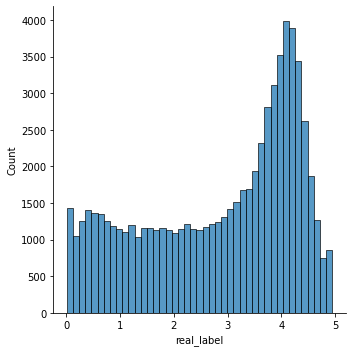

In [ ]:
sns.displot(silver_data['real_label'])

- 좀 더 일반적인 형태로 바꾸기

In [ ]:
def make_balance(x):
  """
  그래프 상의 x축을 기준으로 A, B, C, Z 섹션을 나눠주기 위한 함수
  섹션을 나눠준 기준 : 그래프상에서 가장 undersampling이 필요한 부분을 임의로 나눠줌
  Z섹션은 undersampling이 필요하지 않다고 판단한 부분
  """
  if x <= 3:
    return 'Z' 

  elif (x > 3) & (x < 3.5):
    return 'A'

  elif (x >= 3.5) & (x < 3.8):
    return 'B'

  elif (x >= 3.8) & (x < 4.75):
    return 'C'
  else:
    return 'Z'

* 데이터를 A, B, C, Z섹션으로 나누기 위해 (카테고리를 만들어주기 위해) drop_label이라는 새로운 컬럼을 생성

In [ ]:
silver_data['drop_label'] = silver_data['real_label'].apply(make_balance)

- dataframe을 무작위로 섞고 앞에서부터 순서대로 일정 개수를 drop해주는 방식으로 undersampling

In [ ]:
# 무작위로 섞기
silver_shuffled = silver_data.sample(frac=1).reset_index(drop=True)

In [ ]:
'''
[NOTE]
drop 해주는 개수(2500, 3000, 15000)는 drop후, 그래프의 분포를 봐가며 유동적으로 설정해주었음.
아래는 가장 최적이라고 판단한 개수를 drop한 코드
'''
indexNames = silver_shuffled[ silver_shuffled['drop_label'] == 3.5 ][:2500].index  
silver_shuffled.drop(indexNames , inplace=True)

indexNames = silver_shuffled[ silver_shuffled['drop_label'] == 3.8 ][:3000].index
silver_shuffled.drop(indexNames , inplace=True)

indexNames = silver_shuffled[ silver_shuffled['drop_label'] == 4.75 ][:15000].index
silver_shuffled.drop(indexNames , inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


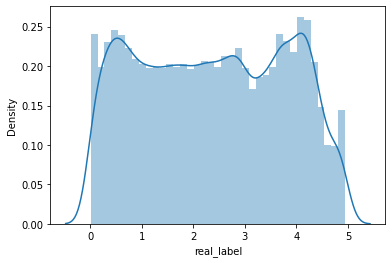

In [ ]:
sns.distplot(silver_shuffled['real_label'])

- Validation에 활용할 새로운 데이터 생성 (2만개)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


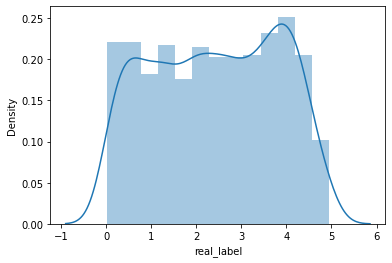

In [ ]:
sampled_df = silver_shuffled.sample(n=2000, random_state=17)
# 아까 만든 drop_label 컬럼 삭제
sampled_df = sampled_df.drop('drop_label', axis=1)

# 마지막으로 distplot 확인
sns.distplot(sampled_df['real_label'])

In [ ]:
sampled_df

,sentence1,sentence2,real_label
21173,우선 위치는 대성당에서 삼분거리로 정말 너무 좋았어요,성당에서 아주 가까워요 아주 좋아요,1.862976
35536,외출할 때 방범 모드로 어떻게 바꿔,외출하려고 하는데 방범 모드는 어떻게 설정할 수 있을까요,3.697177
47933,메일 중 북한이 관리하는 주소로 메일을 보내는 건 금지되어 있습니다,북한에서 관리중인 이메일 주소로 메일을 보내는건 금지되어 있습니다,4.257731
53142,하지만 문제는 그 숙소의 난방이 작동하지 않는다는 것입니다,아파트에 난방은 안 되는 것 같습니다,2.494841
22024,조리기구와 식기도 있고 모두 깨끗합니다,조리 기구와 조미료를 포함한 주방 시설들은 완벽했습니다,2.301458
...,...,...,...
25307,정말 완변한 숙소에서 좋은추억을 만들고 갑니다,좋은 숙소 덕분에 좋은 기억 만들 수 있었어요,3.255745
43486,세탁기와 건조기가 있었던 것이 가장 좋았습니다,식기세척기 세탁기 건조기 있었던게 제일 편했던 것 같아요,3.093371
67775,또한 요양병원 등에 대한 종사자 감염관리교육 예산과 대상을 확대하고 감염관리 기본수...,사업장 내 감염예방 관리 강화를 위해서는 직원 및 이용자 대상 코로나19 질병정보 ...,1.016295
37222,만약 여러분의 짐이 무겁고 크다면 다시 생각해 보세요,캐리어 무겁고 큰 분들은 다시 생각하세요,3.707786


## Train / Valid Re-Split

- 기존의 Train + Valid 데이터를 Train 데이터로
- Augmentaiton을 통해서 얻은 2000개의 데이터를 Valid 데이터로 활용해 하이퍼 파라미터 튜닝 다시 진행

In [ ]:
new_train_data = pd.concat([train_data, valid_data]).reset_index().drop(['index'], axis = 1)
new_train_data

,sentence1,sentence2,real_label,binary_label
0,보안에 문제가 있다는 다른 후기를 본 후 걱정을 많이 했습니다,보안 문제가 있다는 다른 리뷰들을 보고 많이 걱정했어요,4.200000,1
1,청결 위치 조식 등 거의 모든 면에서 만족하였습니다,청결도 위치 아침식사 등 거의 모든 것에 만족했습니다,4.714286,1
2,불합리한 조달기준은 합리적으로 조정하며 기업에 주는 입찰 부담은 최대한 완화한다,불합리한 구매기준은 합리적으로 조정되며 기업의 입찰부담은 최대한 완화됩니다,4.571429,1
3,그녀와 그녀의 어머니의 뛰어난 안목을 느낄수 있는 가구와 소품들이 인상적이었습니다,최고의 숙소와 그녀의 배려가 있었습니다,0.428571,0
4,이번에 피렌체 2박 여행하는 동안 친구와 2이 묵었던 숙소였는데요,여행하는 동안 불편했던 적이 거의 없었던것 같습니다,0.200000,0
...,...,...,...,...
11663,또 숙소가 상가 내에 위치하여 저녁에는 아주 조용합니다,또한 그 숙소는 쇼핑몰에 위치해 있어서 저녁에는 매우 조용합니다,3.714286,1
11664,바로 앞에 슈퍼마켓과 다른가게들이 가까워서 여러가지로 편합니다,주변 상권이나 지하철역 가까워서 도보로 다니기 편합니다,1.333333,0
11665,중장기 복무 제대군인들의 직업훈련이나 전직 지원에도 더 많은 노력을 기울여 주기 바랍니다,중장기적으로 제대군인을 위한 직업훈련과 전근 지원에 더욱 힘써 주시기를 바랍니다,4.000000,1
11666,그치만 성인3명 이상 숙박하기엔 침대가 좀 작을수있으니 그점은 참고하세요,살짝 스트레스 받을 수도 있으니 참고하세요,0.571429,0


In [ ]:
new_valid_data = sampled_df.reset_index().drop(['index'], axis = 1)
new_valid_data

,sentence1,sentence2,real_label
0,우선 위치는 대성당에서 삼분거리로 정말 너무 좋았어요,성당에서 아주 가까워요 아주 좋아요,1.862976
1,외출할 때 방범 모드로 어떻게 바꿔,외출하려고 하는데 방범 모드는 어떻게 설정할 수 있을까요,3.697177
2,메일 중 북한이 관리하는 주소로 메일을 보내는 건 금지되어 있습니다,북한에서 관리중인 이메일 주소로 메일을 보내는건 금지되어 있습니다,4.257731
3,하지만 문제는 그 숙소의 난방이 작동하지 않는다는 것입니다,아파트에 난방은 안 되는 것 같습니다,2.494841
4,조리기구와 식기도 있고 모두 깨끗합니다,조리 기구와 조미료를 포함한 주방 시설들은 완벽했습니다,2.301458
...,...,...,...
1995,정말 완변한 숙소에서 좋은추억을 만들고 갑니다,좋은 숙소 덕분에 좋은 기억 만들 수 있었어요,3.255745
1996,세탁기와 건조기가 있었던 것이 가장 좋았습니다,식기세척기 세탁기 건조기 있었던게 제일 편했던 것 같아요,3.093371
1997,또한 요양병원 등에 대한 종사자 감염관리교육 예산과 대상을 확대하고 감염관리 기본수...,사업장 내 감염예방 관리 강화를 위해서는 직원 및 이용자 대상 코로나19 질병정보 ...,1.016295
1998,만약 여러분의 짐이 무겁고 크다면 다시 생각해 보세요,캐리어 무겁고 큰 분들은 다시 생각하세요,3.707786


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


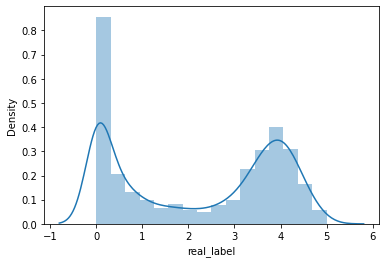

In [ ]:
sns.distplot(new_train_data['real_label'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


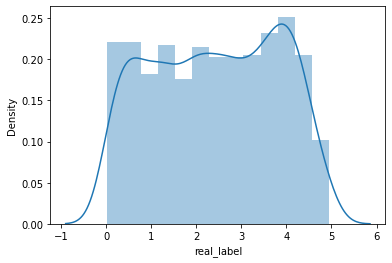

In [ ]:
sns.distplot(new_valid_data['real_label'])

# 5.Data Augmentation의 효과

## A) HyperParameterTuning

In [ ]:
new_train_dataset = CustomDataset(new_train_data)
new_valid_dataset = CustomDataset(new_valid_data)
test_dataset = CustomDataset(test_data)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size = 32, sampler = SequentialSampler(test_dataset), collate_fn = partial(custom_collate_fn, max_length= 128))

Sweep 
- 가장 성능이 좋았던 하이퍼 파라미터로 실행
- 실제 실행 시 고려했던 옵션들은 주석으로 처리
- 10 Epoch로 실행한 후 3 번째 Epoch에서 저장한 check point가 가장 높은 성능

=> Scheduler 특성 때문에 10 Epoch 실행 후 3번째 Epoch check point를 저장한 결과와
3 Epoch 실행 후 check point 저장한 결과가 다름 
- 이때 3번째 Epoch에서 Valid loss가 상승했지만 test에선 오히려 좋은 결과

![image](https://user-images.githubusercontent.com/86637320/159871373-6435891c-b130-4f2c-8883-d53b1ea022c8.png)

- RandomSampler의 seed를 따로 설정해주지 않아 재현엔 실패.

[참고](https://pytorch.org/docs/stable/generated/torch.Generator.html#torch.Generator)

- 노트북엔 과정을 전반적으로 소개

모델의 최종 결과는 다음과 같았음.      


F1 : 86.68076109936574   
Pearsonr : 93.31220771751511    

추론 결과는 dev_set_socre 노트북에 기록.

In [ ]:
sweep_config = {
    
    "name" : "wandb-sts",   
    "method": "bayes",
    "metric": {
        "name" : "total_valid_loss", 
        "goal" : "minimize"
                },
    
    "parameters": { 
        "epochs" : {
            "distribution" : "categorical",
            "values" : [10]},                       #10 epcoh로 실행 후 3번째 check point가 최고 성능.
        "learning_rate" : {
            "distribution" : "categorical",
            "values" : [3e-5]},                     #[3e - 5, 5e- 5]
        "eps" : {
            "distribution" : "categorical",
            "values" : [1e-8]
        },
        "train_batch_size" : {
            "distribution" : "categorical",
            "values" : [32]
        },
        "valid_batch_size" : {
            "distribution" : "categorical",
            "values" : [64]
        },
        "weight_decay" : {
            "distribution" : "categorical",
            "values" : [0.01]
        },
        "warm_up_ratio" : {
            "distribution" : "categorical",
            "values" : [0]
        },
        "max_length" : {
            "distribution" : "categorical",       #[128, 80]
            "values" : [128]
        },
        "grad_norm" : {
            "distribution" : "categorical",
            "values" : [1.0]
        },
    },         
    "early_terminate" : {
        "type": "hyperband", # metric이 2번 이상 개선되지 않을 경우 조기 종료
        "min_iter" : 2,
        "eta" : 2
        }
}

- 매 Epoch 저장하기 위해서 수정 check_point, sweep 정보 수정

In [ ]:
def save_checkpoint(model, optimizer, scheduler, epoch, loss):
    '''
    torch.save 함수 이용하여 model 정보 저장
    불필요한 반복방지 및 GPU memory 공간 renewal에  활용
    '''
    file_name = f'./model.ckpt.{epoch}'
        
    # torch.save 함수 참고
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss' : loss
        }, 
        file_name
    )
    
    print(f"Saving epoch {epoch} checkpoint at {file_name}")

In [ ]:
from torch.nn.utils import clip_grad_norm_

def sweep(model, train_dataloader, valid_dataloader, optimizer, scheduler, device, config, wandb, text_table):   
    """
    하이퍼 파라미터 과정을 wandb로 기록합니다.
    """
    # parameter, graident 변화 기록
    wandb.watch(model, log="all", log_freq = 10)
    # 성능 확인
    best_val_loss = float('inf')
    model.to(device)
      
    for epoch in range(config.epochs):
        
        model.train()
        total_loss, batch_loss, batch_count = 0,0,0
        
        for step, batch in enumerate(train_dataloader):
            
            model.zero_grad()
            batch_count += 1
            batch = tuple(item.to(device) for item in batch)
            batch_input, batch_label = batch

            #forward
            outputs = model(**batch_input, labels = batch_label.float())
            loss = outputs.loss #MSELoss
            
            batch_loss += loss.item()
            total_loss += loss.item()

            # 자동미분
            loss.backward()
             
            #gradient_clipping
            clip_grad_norm_(model.parameters(), config.grad_norm)

            # optimizer, scheduler 업데이트
            optimizer.step()
            scheduler.step()

            
            if (step % 10) == 0 and step != 0:
                wandb.log({'train_loss': batch_loss / batch_count, 'train_lr': optimizer.param_groups[0]['lr']})
                print(f"Step : {step + 1}, train Loss : {batch_loss / batch_count:.4f}")                      
                # reset 
                batch_loss, batch_count = 0,0
                
        wandb.log({'total_train_loss': total_loss / (step + 1), 'total_train_lr': optimizer.param_groups[0]['lr'], "epoch" : (epoch + 1)})
        print(f"Epoch {epoch} total_train_loss : {total_loss/(step+1):.4f}")
        print(f"*****Epoch {epoch} Train Finish*****\n") 

        print(f"*****Epoch {epoch} Valid Start*****")
        total_valid_loss = validate(model, valid_dataloader, device, wandb, text_table, epoch)
        print(f"Epoch {epoch} total_Valid Loss : {total_valid_loss:.4f}") 
        print(f"*****Epoch {epoch} Valid Finish*****\n")
        # 매번 epoch마다 checkpoint 저장
        save_checkpoint(model, optimizer, scheduler,  epoch, total_valid_loss) #scheduler,

    print("Train Finished")

In [ ]:
import wandb
from transformers import AdamW, get_linear_schedule_with_warmup
def run_sweeep(config=None):
    """
    설정에 맞춰서 wandb sweep 실행.
    """
    wandb.init(config=config)
    
    w_config = wandb.config   
    train_dataloader, valid_dataloader = sweep_dataset(w_config.train_batch_size, w_config.valid_batch_size, w_config.max_length, new_train_dataset, new_valid_dataset)   
    model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels = 1)  
    
    no_decay = ['bias', 'LayerNorm.weight']
    #Not decay bias, LayerNorm.weight
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': w_config.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    

    optimizer = AdamW(optimizer_grouped_parameters, lr = w_config.learning_rate, eps = w_config.eps) 
    num_training_steps = w_config.epochs * len(train_dataloader)
    scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps= (num_training_steps * w_config.warm_up_ratio), \
        num_training_steps = num_training_steps)
    
    text_table = wandb.Table(columns=["epoch", "step", "text", 'true_label', 'pred_label'])
    sweep(model, train_dataloader, valid_dataloader, optimizer, scheduler, device, w_config, wandb, text_table)
    wandb.log({f"error-text-{wandb.run.name}" : text_table})

In [ ]:
sweep_id = wandb.sweep(sweep_config, project = "wandb-sts-aug")
wandb.agent(sweep_id, run_sweeep, count = 1)

Create sweep with ID: cjzn5qzm
Sweep URL: https://wandb.ai/woodywarhol99/wandb-sts-aug/sweeps/cjzn5qzm


wandb: Agent Starting Run: jf5vbehl with config:
wandb: 	epochs: 10
wandb: 	eps: 1e-08
wandb: 	grad_norm: 1
wandb: 	learning_rate: 3e-05
wandb: 	max_length: 128
wandb: 	train_batch_size: 32
wandb: 	valid_batch_size: 64
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0.01


Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

Step : 11, train Loss : 5.7771
Step : 21, train Loss : 3.6332
Step : 31, train Loss : 2.3782
Step : 41, train Loss : 1.2079
Step : 51, train Loss : 0.6164
Step : 61, train Loss : 0.3148
Step : 71, train Loss : 0.3309
Step : 81, train Loss : 0.3093
Step : 91, train Loss : 0.2700
Step : 101, train Loss : 0.2369
Step : 111, train Loss : 0.2495
Step : 121, train Loss : 0.3023
Step : 131, train Loss : 0.2492
Step : 141, train Loss : 0.2259
Step : 151, train Loss : 0.2254
Step : 161, train Loss : 0.2307
Step : 171, train Loss : 0.2185
Step : 181, train Loss : 0.2159
Step : 191, train Loss : 0.1892
Step : 201, train Loss : 0.2205
Step : 211, train Loss : 0.1699
Step : 221, train Loss : 0.1580
Step : 231, train Loss : 0.2005
Step : 241, train Loss : 0.1954
Step : 251, train Loss : 0.2077
Step : 261, train Loss : 0.2450
Step : 271, train Loss : 0.2587
Step : 281, train Loss : 0.2324
Step : 291, train Loss : 0.1890
Step : 301, train Loss : 0.2155
Step : 311, train Loss : 0.2300
Step : 321, train

wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
# for CUDA debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# torch.load 로 checkpoint 불러오기

import torch

# device type
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"# available GPUs : {torch.cuda.device_count()}")
        print(f"GPU name : {torch.cuda.get_device_name()}")
    else:
        device = torch.device("cpu")
    return device

device = set_device()

checkpoint = torch.load('./model.ckpt.2',map_location=device)

checkpoint['epoch'], checkpoint['loss']

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB


(2, 0.1138812955468893)

In [ ]:
from transformers import ElectraForSequenceClassification, ElectraTokenizer

model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels = 1)  # KoELECTRA-Base-v3
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator") 

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import f1_score
import numpy as np

def test(model, dataloader, device):    
    """
    훈련된 모델의 Test Dataset 성능을 확인합니다.
    """  
    model.to(device)
    model.eval()
    
    total_loss = 0
    batch_count, batch_loss = 0, 0
    preds_np = None

    for step, batch in enumerate(dataloader):       
        batch_count += 1
        batch = tuple(item.to(device) for item in batch)

        batch_input, batch_label = batch

        with torch.no_grad():
            outputs = model(**batch_input, labels = batch_label)
    
        loss = outputs.loss
        preds = outputs.logits.squeeze()

        
        # 모델 예측 값과 Label 값 저장.
        if preds_np is None:
            preds_np = preds.detach().cpu().numpy()
            labels_np = batch_label.detach().cpu().numpy()
        else:
            preds_np = np.append(preds_np, preds.detach().cpu().numpy(), axis=0)
            labels_np = np.append(labels_np, batch_label.detach().cpu().numpy(), axis=0)
        
        batch_loss += loss.item()
        total_loss += loss.item()
                        
        # 배치 처리할 때마다 평균 loss와 f1_score, pearsonr을 출력
        if (step % 10) == 0 and step != 0:
            print('test_loss : ' ,batch_loss / batch_count)                           
            batch_loss, batch_count = 0, 0

    total_valid_loss = total_loss / (step + 1)
    # binary_preds
    preds_f = np.where(preds_np >=3, 1, 0)
    labels_f = np.where(labels_np >=3, 1, 0)
       
    f_score = f1_score(preds_f, labels_f) * 100
    p_score = pearsonr(preds_np, labels_np)[0] * 100           
    print('total_test_loss : ' , total_valid_loss, "total_f1_score : " , f_score, "total_pearsonr:" , p_score)

In [ ]:
test(model, test_dataloader, device)

test_loss :  0.4360206828647168
total_test_loss :  0.41405145553548856 total_f1_score :  84.73895582329318 total_pearsonr: 92.27130842065094


## B) 효과 확인

- 해당 노트북 결과 이외에도 다양한 실험을 진행했음.
- 다양한 실험 결과 새로운 Data를 Validation에 활용하면 Valid loss가 완만하게 줄어듦
- Valid loss가 완만하게 줄어들지만 꼭 Test Set에서의 성능 향상으로 이어지지는 않음

기존 Valid Data

![image](https://user-images.githubusercontent.com/86637320/159854421-6c6f471b-77bb-4385-9493-fe317b99ee98.png)

![image](https://user-images.githubusercontent.com/86637320/159855575-5ffc626b-85bb-42c7-996e-8ed29f2fc636.png)

New Valid Data

![image](https://user-images.githubusercontent.com/86637320/159854343-644abeb9-3ca6-473f-95d2-124afaec58bc.png)

## C) 개선 방안

![image](https://user-images.githubusercontent.com/86637320/159863301-cb472f02-1b89-4da7-8133-2dbb2a070d4f.png)

Augmented Data의 품질을 높이면 더 좋은 결과 기대할 수 있음.       
노트북에선 Semantic Search(S.S)까지만 진행했지만 추가로 BM25 샘플링을    적용해보면 좋을 것.